In [54]:
suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))
options(future.globals.maxSize= 891289600 * 160)
# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [55]:
outDir='/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/3species_compare_240130/LHX6/'
marmoset_sub=readRDS(paste0(outDir,'marmoset_LHX6.rds'))
mouse_sub=readRDS(paste0(outDir,'mouse_LHX6.rds'))
macaque_sub=readRDS(paste0(outDir,'macaque_LHX6.rds'))


In [56]:
marmoset=marmoset_sub
mouse=mouse_sub
macaque=macaque_sub

test=read.table('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/3species_compare_240227_merge_anno/mart_export.txt',sep="\t",header=T)

comGeneTb = test[c("Marmoset.gene.name", "Gene.name", "Mouse.gene.name")]
colnames(comGeneTb)=c('marmosetGene','macaqueGene','mouseGene')
comGeneTb=comGeneTb[grep('[A-Za-z]',comGeneTb$marmosetGene),]
comGeneTb=comGeneTb[grep('[A-Za-z]',comGeneTb$macaqueGene),]
comGeneTb=comGeneTb[grep('[A-Za-z]',comGeneTb$mouseGene),]
prepareHomoSeurat = function(seurat, originalGeneName, homoGeneName, keepMetaCol, commonMetaCol, speciesPrefix="macaque_", clusterCol="anno3") {
    homoCountMx = seurat[["RNA"]]@counts[originalGeneName,]
    rownames(homoCountMx) = homoGeneName
    colnames(homoCountMx) = paste0(speciesPrefix, colnames(homoCountMx))
    homoSeurat = CreateSeuratObject(counts=homoCountMx)
    tmpDf = seurat@meta.data[sub(speciesPrefix, "", rownames(homoSeurat@meta.data)), keepMetaCol]
    tmpDf$species = sub("(_|-)", "", speciesPrefix)
    tmpDf$clusterName = paste0(speciesPrefix, tmpDf[[clusterCol]])
    commonMetaCol = c(commonMetaCol, "species", "clusterName")
    colnames(tmpDf) = ifelse(
        colnames(tmpDf) %in% commonMetaCol, colnames(tmpDf),
        paste0(speciesPrefix, colnames(tmpDf))
    )
    rownames(tmpDf) = paste0(speciesPrefix, rownames(tmpDf))
    homoSeurat = AddMetaData(homoSeurat, metadata=tmpDf)
    return(homoSeurat)
}

comGeneTb$homoGeneSymbol = comGeneTb$macaqueGene
comGeneTb = subset(
    comGeneTb, 
    marmosetGene %in% rownames(marmoset[["RNA"]]@counts) & 
    macaqueGene %in% rownames(macaque[["RNA"]]@counts) &
    mouseGene %in% rownames(mouse[["RNA"]]@counts)
)

macaque$sample=macaque$donor2


macaqueHomoSeurat = prepareHomoSeurat(
    macaque, originalGeneName=comGeneTb$macaqueGene, homoGeneName=comGeneTb$homoGeneSymbol,
    keepMetaCol=c("nCount_RNA", "nFeature_RNA",'percent.mt','SuperCluster','Cluster','sample'),
    commonMetaCol=c("nCount_RNA", "nFeature_RNA"),
    speciesPrefix="macaque_", clusterCol="Cluster"
)

macaque
macaqueHomoSeurat

marmosetHomoSeurat = prepareHomoSeurat(
    marmoset, originalGeneName=comGeneTb$marmosetGene, homoGeneName=comGeneTb$homoGeneSymbol,
    keepMetaCol=c("nCount_RNA",'percent.mt', "nFeature_RNA",'SuperCluster','Cluster','sample'),
    commonMetaCol=c("nCount_RNA", "nFeature_RNA"),
    speciesPrefix="marmoset_", clusterCol="Cluster"
)

marmoset
marmosetHomoSeurat


mouseHomoSeurat = prepareHomoSeurat(
    mouse, originalGeneName=comGeneTb$mouseGene, homoGeneName=comGeneTb$homoGeneSymbol,
    keepMetaCol=c("nCount_RNA",'percent.mt', "nFeature_RNA",'SuperCluster','Cluster','sample'),
    commonMetaCol=c("nCount_RNA", "nFeature_RNA"),
    speciesPrefix="mouse_", clusterCol="Cluster"
)

mouse
mouseHomoSeurat

mouseHomoSeurat$species='mouse'
marmosetHomoSeurat$species='marmoset'
macaqueHomoSeurat$species='macaque'


Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


An object of class Seurat 
43267 features across 4168 samples within 2 assays 
Active assay: SCT (21304 features, 21304 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

An object of class Seurat 
13429 features across 4168 samples within 1 assay 
Active assay: RNA (13429 features, 0 variable features)

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


An object of class Seurat 
63792 features across 1096 samples within 2 assays 
Active assay: SCT (30873 features, 30873 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

An object of class Seurat 
13429 features across 1096 samples within 1 assay 
Active assay: RNA (13429 features, 0 variable features)

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


An object of class Seurat 
91564 features across 545 samples within 2 assays 
Active assay: SCT (42856 features, 42856 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

An object of class Seurat 
13429 features across 545 samples within 1 assay 
Active assay: RNA (13429 features, 0 variable features)

In [57]:
merge1=merge(mouseHomoSeurat,marmosetHomoSeurat)
merge2=merge(merge1,macaqueHomoSeurat)


In [58]:
classFiltSeurat=merge2
classFiltSeurat = SCTransform(
classFiltSeurat, assay="RNA",
ncells=ncol(classFiltSeurat[["RNA"]]),
variable.features.n=5000,
#return.only.var.genes = T,
#vars.to.regress="percent.mt",
method="glmGamPoi"
)
classFiltSeurat = classFiltSeurat %>%
RunPCA(npcs=100, verbose = FALSE) %>%
FindNeighbors(dims = 1:50) %>%
FindClusters(verbose = FALSE) %>%
RunUMAP(dims = 1:50)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 12415 by 5809

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5809 cells



  |======================================================================| 100%


Found 22 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 12415 genes



  |======================================================================| 100%


Computing corrected count matrix for 12415 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.041669 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Computing nearest neighbor graph

Computing SNN

16:51:10 UMAP embedding parameters a = 0.9922 b = 1.112

16:51:10 Read 5809 rows and found 50 numeric columns

16:51:10 Using Annoy for neighbor search, n_neighbors = 30

16:51:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:51:11 Writing NN index file to temp file /tmp/Rtmpr0WjAF/file2613f226c4d0e

16:51:11 Searching Annoy index using 1 thread, search_k = 3000

16:51:12 Annoy recall = 100%

16:51:13 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:51:15 Initializing from

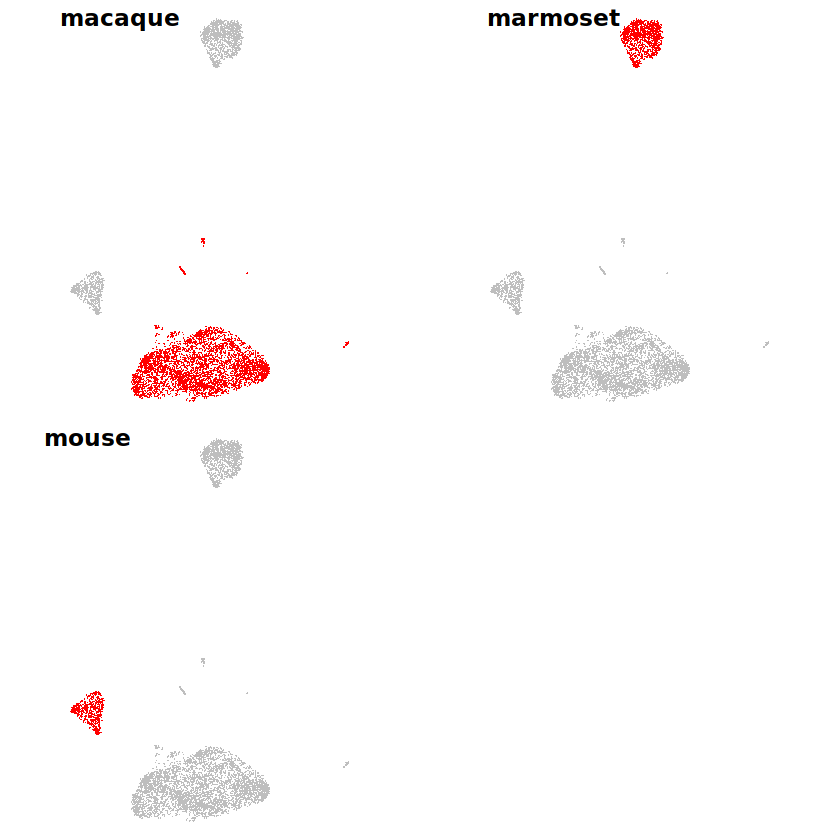

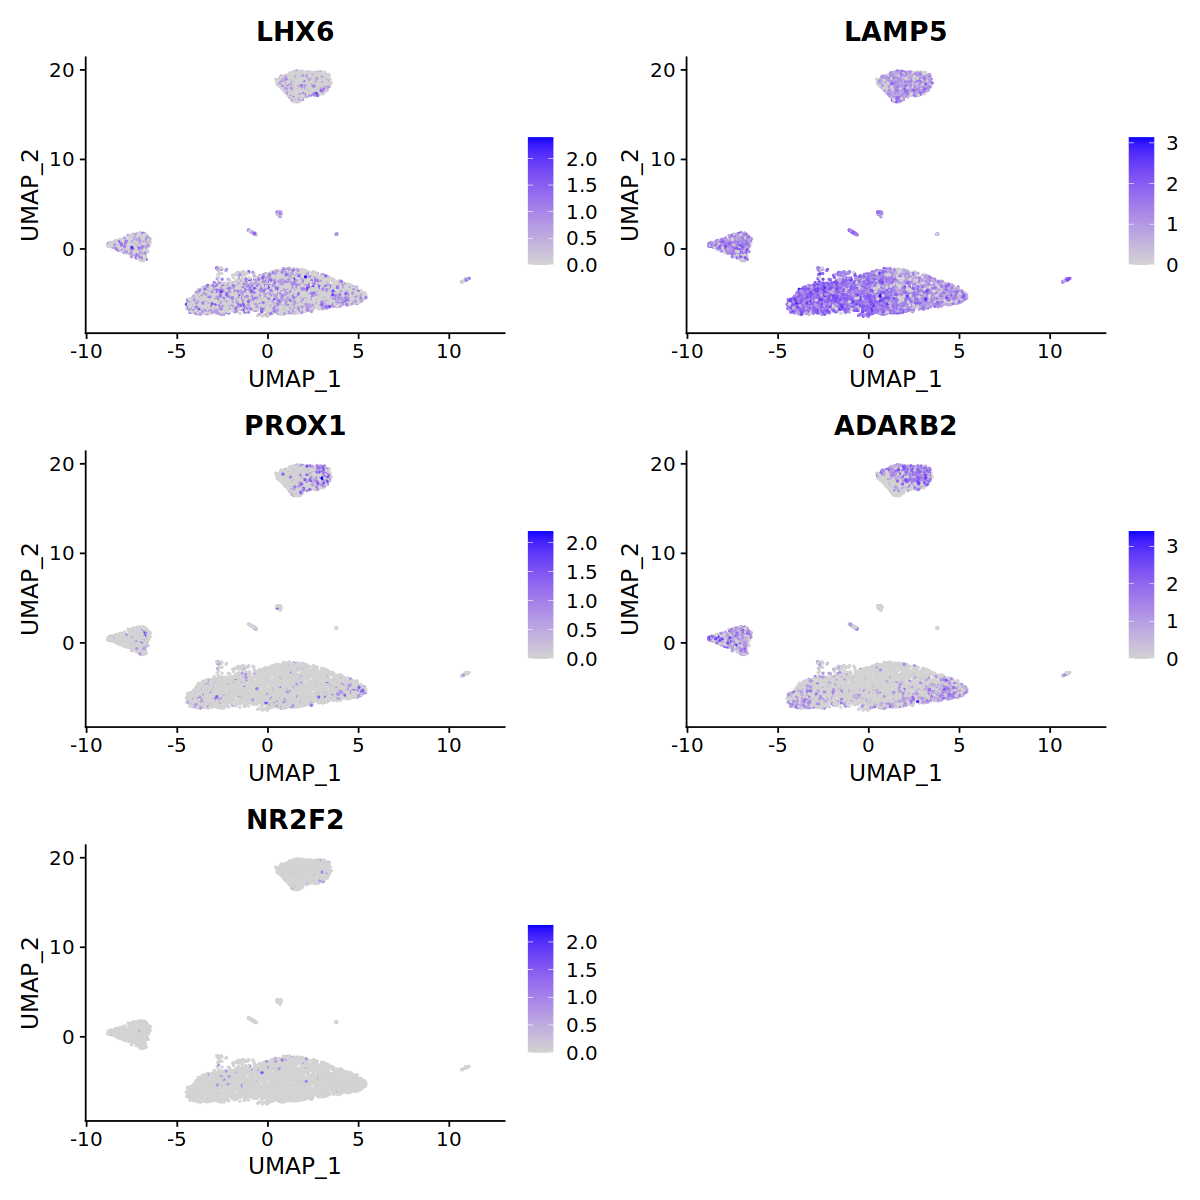

In [59]:
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}
options(repr.plot.width=7, repr.plot.height=7)
myHighlightDimPlot(classFiltSeurat, highlightBy="species", showAllPoints=T, size=0.1)


classMarkerTop = c('LHX6','LAMP5','PROX1','ADARB2','NR2F2')

options(repr.plot.width=10, repr.plot.height=10)
FeaturePlot(classFiltSeurat, features = classMarkerTop,raster=FALSE)


Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.SCT.harmony; see ?make.names for more details on syntax validity”
Computing nearest neighbor graph

Computing SNN

16:51:50 UMAP embedding parameters a = 0.9922 b = 1.112

16:51:50 Read 5809 rows and found 10 numeric columns

16:51:50 Using Annoy for neighbor search, n_neighbors = 30

16:51:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:51:50 Writing NN index file to temp file /tmp/Rtmpr0WjAF/file2613f5938cc2

16:51:50 Searching Annoy index using 1 thread, search_k = 3000

16:51:52 Annoy recall = 100%

16:51:53 Commencing smooth kNN distance calibration using 1 thread
 with target

An object of class Seurat 
25844 features across 5809 samples within 2 assays 
Active assay: SCT (12415 features, 5000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

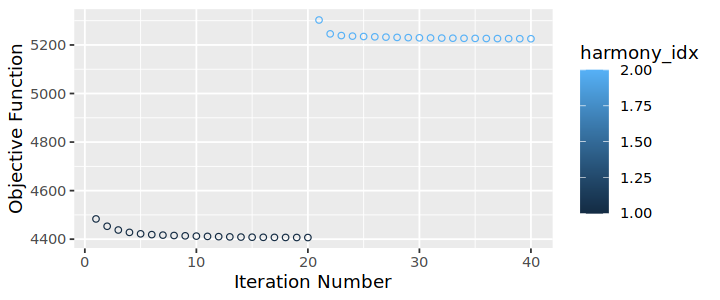

In [60]:

# Run harmony
DefaultAssay(classFiltSeurat) = "SCT"
options(repr.plot.width=6, repr.plot.height=2.5)
classFiltSeurat = RunHarmony(
classFiltSeurat, group.by.vars="species", plot_convergence=T,
assay.use="SCT", reduction = "pca", dims.use=1:10
)
classFiltSeurat = classFiltSeurat %>%
FindNeighbors(reduction="harmony", dims = 1:10) %>%
FindClusters(verbose = FALSE,resolution = 0.2) %>%
RunUMAP(reduction="harmony", dims = 1:10)
return(classFiltSeurat)


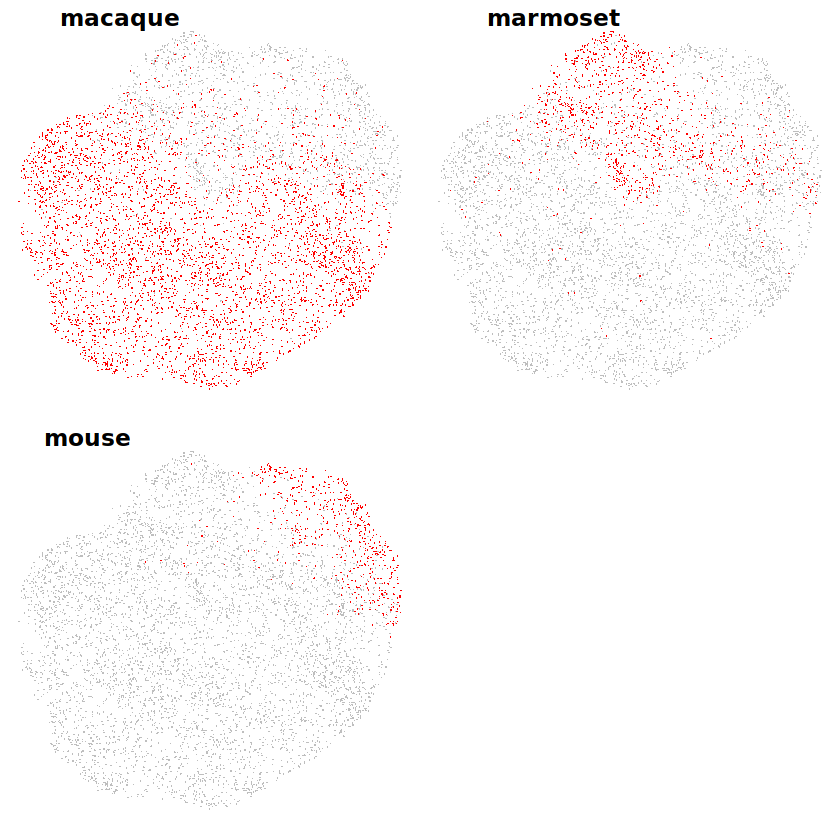

In [61]:
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}
options(repr.plot.width=7, repr.plot.height=7)
myHighlightDimPlot(classFiltSeurat, highlightBy="species", showAllPoints=T, size=0.1)


In [9]:
classFiltSeurat$Cluster='test'
classFiltSeurat@meta.data[classFiltSeurat@meta.data$seurat_clusters==0,]$Cluster='Lamp5/LHX6/ADARB-/1'
classFiltSeurat@meta.data[classFiltSeurat@meta.data$seurat_clusters==1,]$Cluster='Lamp5/LHX6/ADARB+/2'
classFiltSeurat@meta.data[classFiltSeurat@meta.data$seurat_clusters==2,]$Cluster='Lamp5/LHX6/ADARB+/3'
classFiltSeurat@meta.data[classFiltSeurat@meta.data$seurat_clusters==3,]$Cluster='Lamp5/LHX6/ADARB-/4'



In [16]:
brewer.pal(11,'RdBu')

[1] "#67001F" "#B2182B" "#D6604D" "#F4A582" "#FDDBC7" "#F7F7F7" "#D1E5F0"
 [8] "#92C5DE" "#4393C3" "#2166AC" "#053061"

In [42]:
col_d=c(brewer.pal(11,'RdBu')[11],
       brewer.pal(11,'RdBu')[1],
       brewer.pal(11,'RdBu')[9],
       brewer.pal(11,'RdBu')[3])
names(col_d)=unique(classFiltSeurat$Cluster)
col_d

Lamp5/LHX6/ADARB+/3 Lamp5/LHX6/ADARB-/1 Lamp5/LHX6/ADARB+/2 Lamp5/LHX6/ADARB-/4 
          "#053061"           "#67001F"           "#4393C3"           "#D6604D"

In [43]:
brewer.pal(4,'RdBu')

[1] "#CA0020" "#F4A582" "#92C5DE" "#0571B0"

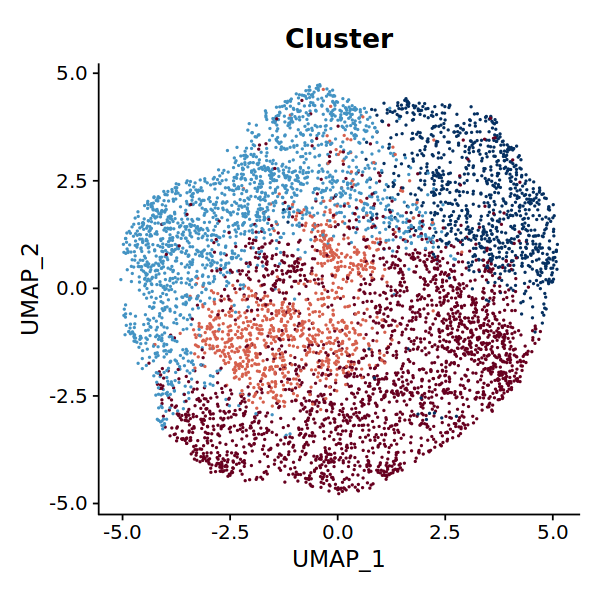

In [44]:
options(repr.plot.width=5, repr.plot.height=5)
gp1=DimPlot(classFiltSeurat, reduction="umap", group.by="Cluster", cols = col_d,label=F,raster=FALSE)+coord_fixed()+NoLegend()
gp1



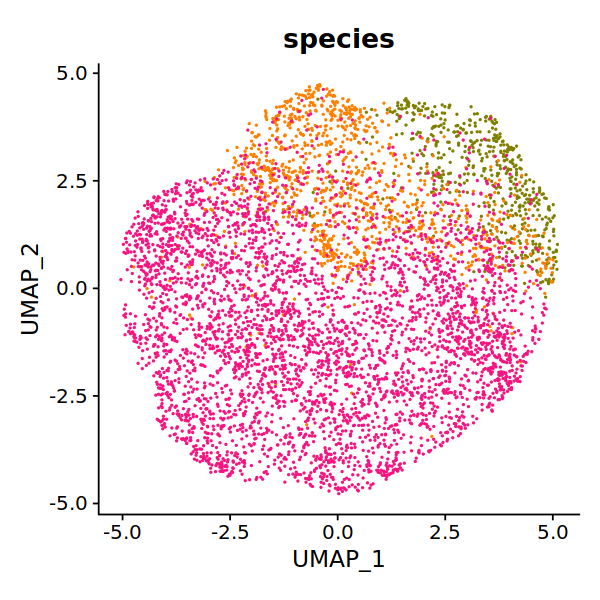

In [45]:
colorLeg = c("marmoset"="#FF8000", "macaque"="#F71480", "mouse"="#808000")

options(repr.plot.width=5, repr.plot.height=5)
gp2=DimPlot(classFiltSeurat, reduction="umap", group.by="species", cols = colorLeg,label=F,raster=FALSE)+coord_fixed()+NoLegend()
gp2


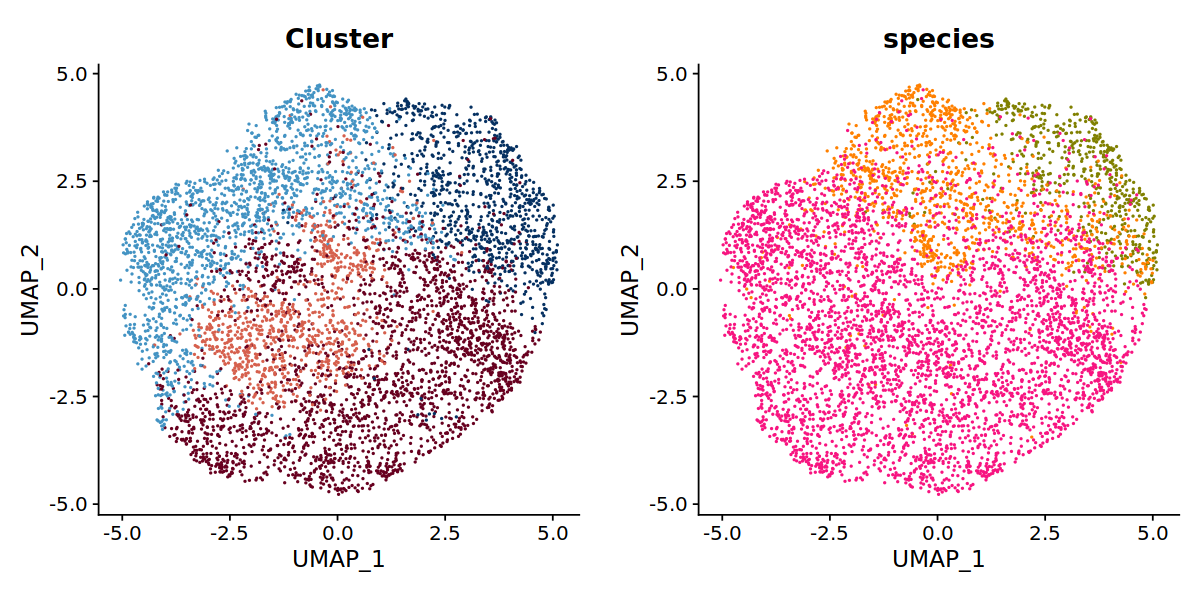

In [46]:
options(repr.plot.width=10, repr.plot.height=5)
gp3=plot_grid(gp1,gp2)
gp3

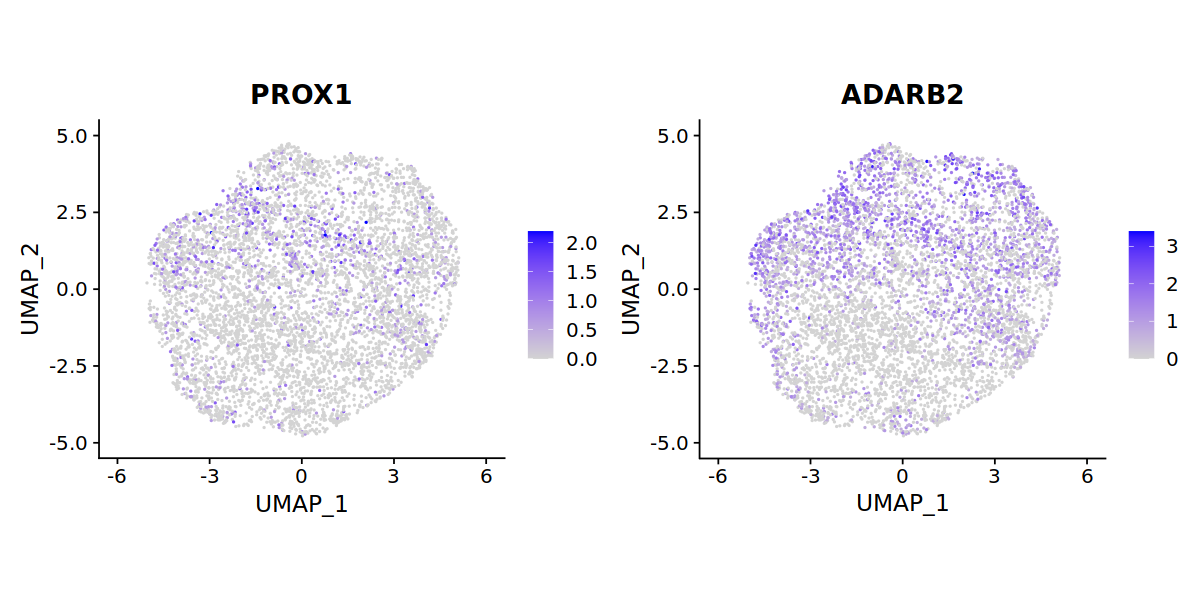

In [47]:

classMarkerTop = c('PROX1','ADARB2')

options(repr.plot.width=10, repr.plot.height=5)
gp4=FeaturePlot(classFiltSeurat, features = classMarkerTop,raster=FALSE)+coord_fixed()

gp4

In [48]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/fig6_renew_240307_LHX6/umap11.pdf", width=10, height=5)
gp3
dev.off()


pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/fig6_renew_240307_LHX6/umap2.pdf", width=10, height=5)
gp4
dev.off()



png 
  2

png 
  2

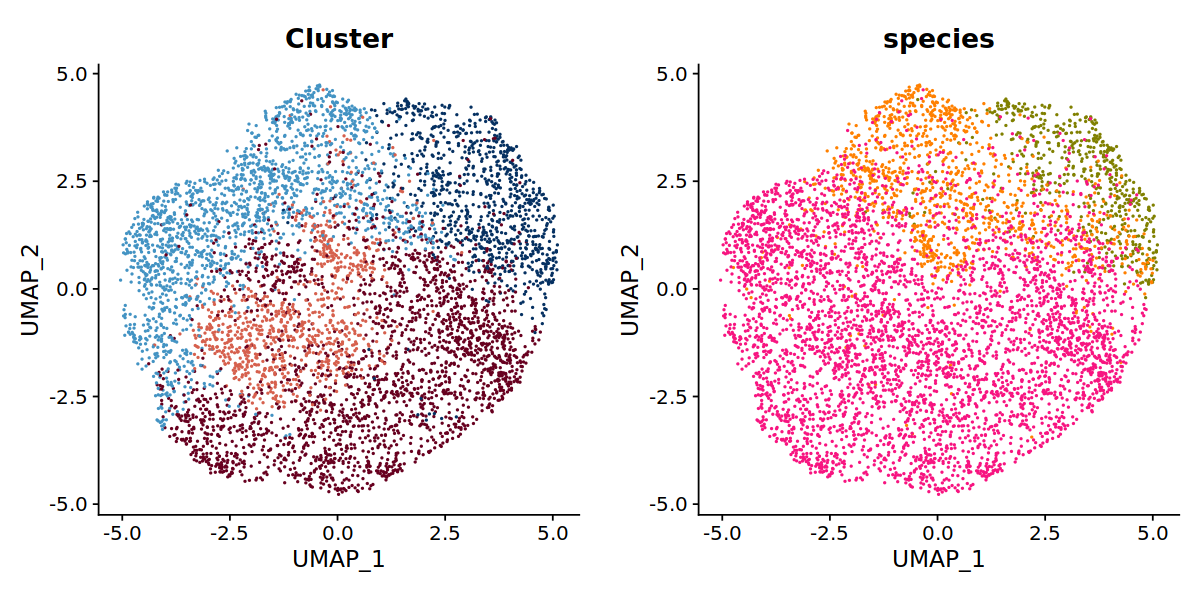

In [49]:
gp3

Warning message in FetchData.Seurat(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: TAC1”
Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found: TAC1”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


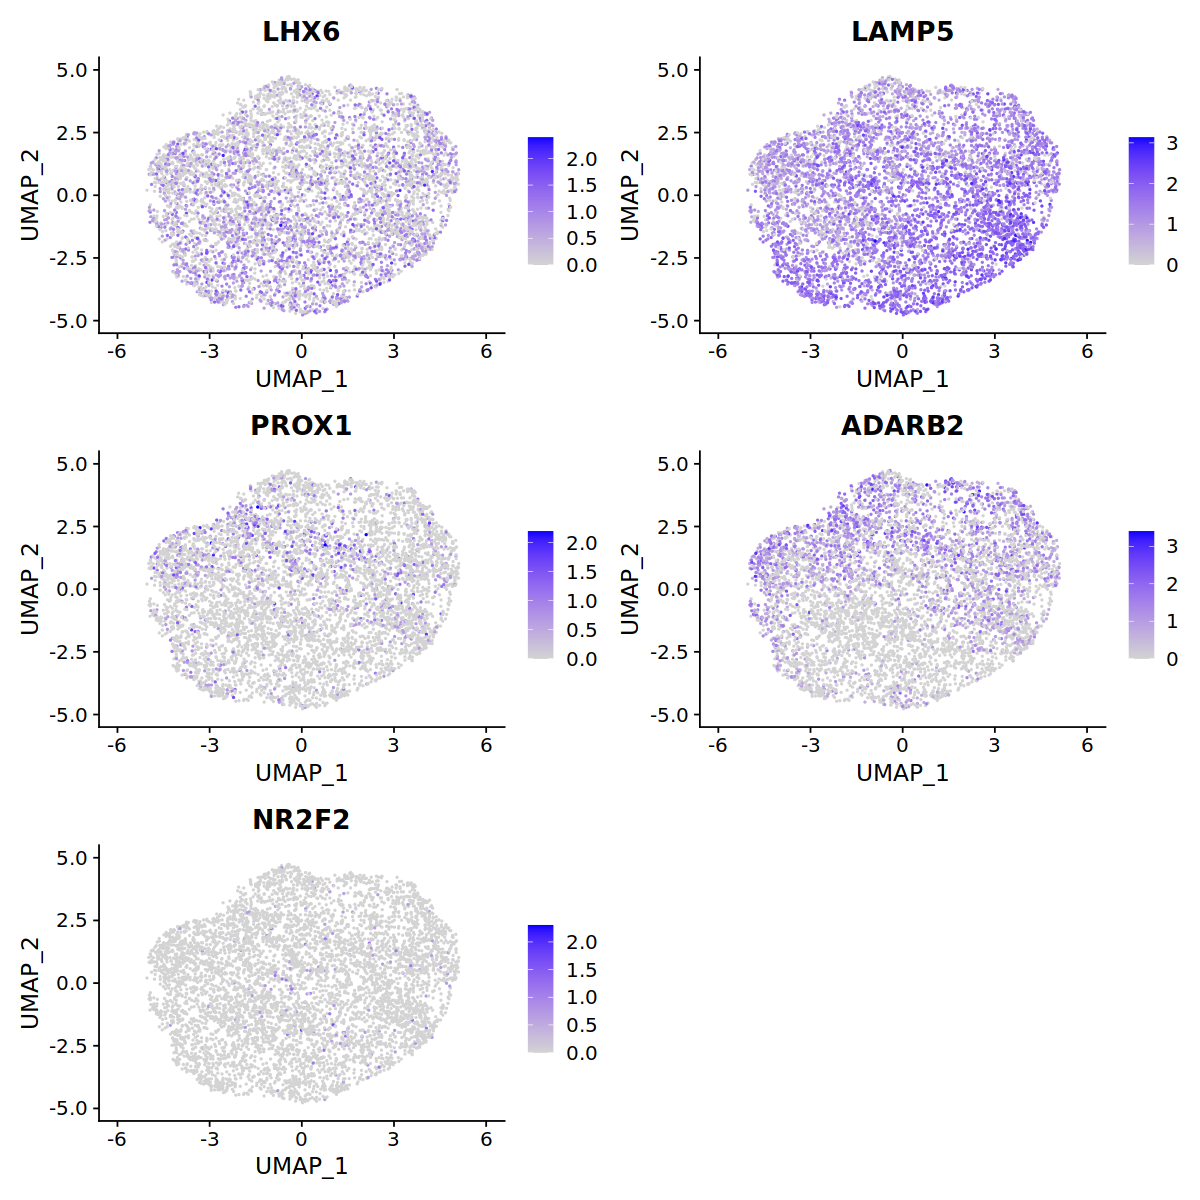

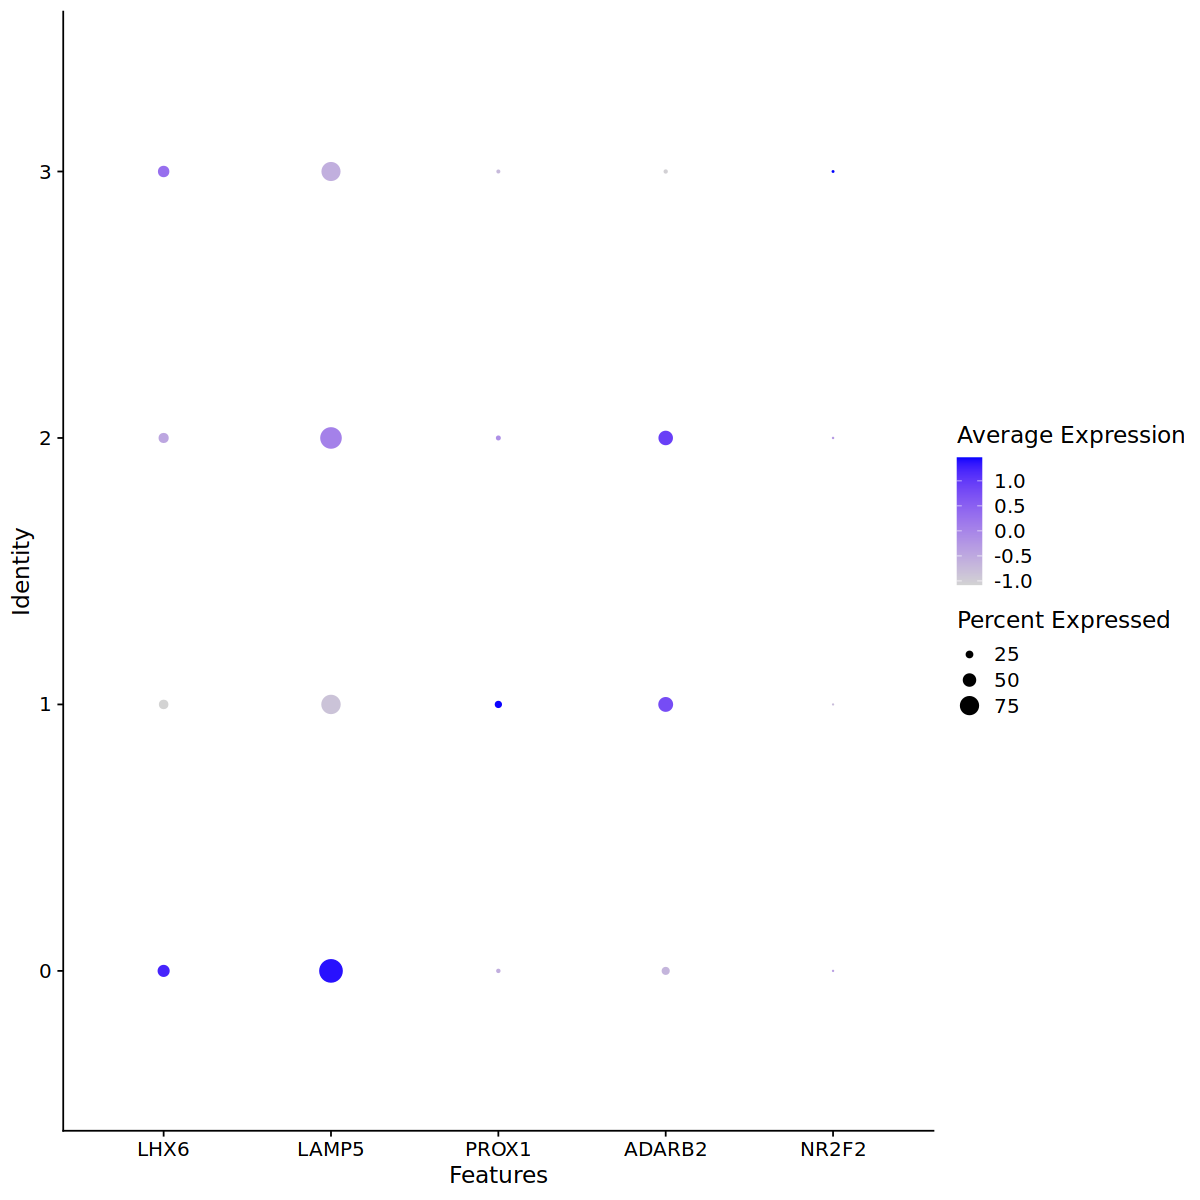

In [51]:

classMarkerTop = c('LHX6','TAC1','LAMP5','PROX1','ADARB2','NR2F2')

options(repr.plot.width=10, repr.plot.height=10)
FeaturePlot(classFiltSeurat, features = classMarkerTop,raster=FALSE)

Idents(classFiltSeurat)='seurat_clusters'
DotPlot(classFiltSeurat, features = classMarkerTop)


Joining, by = "species"
`summarise()` has grouped output by 'Cluster'. You can override using the
`.groups` argument.
Joining, by = "Cluster"


Cluster             species  part_num   sum_num  ratio     
1 Lamp5/LHX6/ADARB-/1 macaque  3126.10053 3534.681 0.88440801
2 Lamp5/LHX6/ADARB-/1 marmoset  323.31113 3534.681 0.09146825
3 Lamp5/LHX6/ADARB-/1 mouse      85.26972 3534.681 0.02412374
4 Lamp5/LHX6/ADARB-/4 macaque   964.45010 1934.617 0.49852252
5 Lamp5/LHX6/ADARB-/4 marmoset  927.53193 1934.617 0.47943959
6 Lamp5/LHX6/ADARB-/4 mouse      42.63486 1934.617 0.02203788

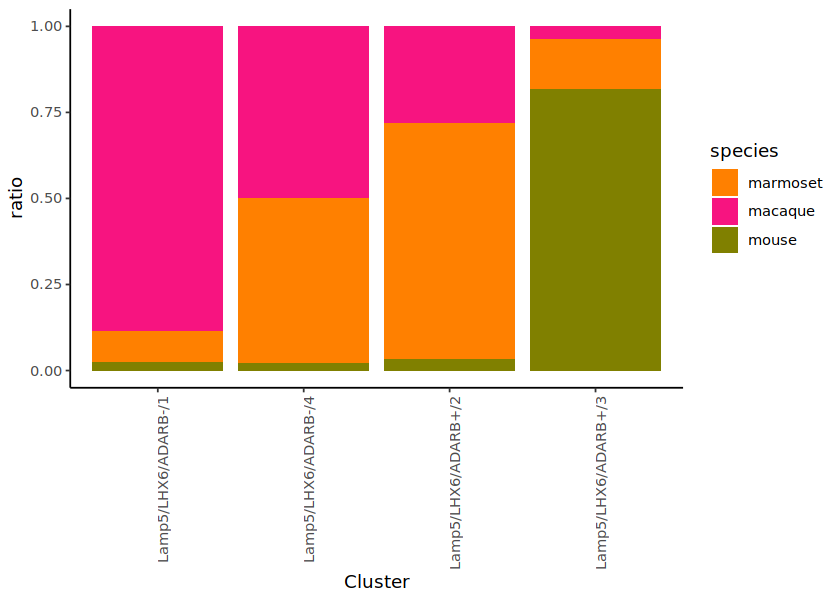

In [52]:

cla=classFiltSeurat
df_sum=cla@meta.data
#normalize
df_sum$num=1
df_donor=as.data.frame(table(df_sum$species))
colnames(df_donor)=c('species','all_num')
df_donor$ratio=df_donor$all_num/sum(df_donor$all_num)
df_donor$weight=1/df_donor$ratio
df_donor=df_donor[,c('species','weight')]
df_sum=left_join(df_sum,df_donor)
df_sum$num=df_sum$num*df_sum$weight

df1=df_sum %>% group_by(Cluster,species) %>% summarise(part_num=sum(num))
df2=df_sum %>% group_by(Cluster) %>% summarise(sum_num=sum(num))
df1=left_join(df1,df2)

df1$ratio=df1$part_num/df1$sum_num

head(df1)
#df1$Cluster=factor(df1$Cluster,levels = order)
options(repr.plot.width=7, repr.plot.height=5)
colorLeg = c("marmoset"="#FF8000", "macaque"="#F71480", "mouse"="#808000")

p1=ggplot(data = df1, aes(x = Cluster, y = ratio, fill = species)) +
 geom_bar(stat = "identity", position = "stack")+theme_classic()+
scale_fill_manual(values = colorLeg)+ theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1))

p1


In [53]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/fig6_renew_240307_LHX6/species_bar.pdf", width=7, height=5)
p1
dev.off()


png 
  2

In [54]:
DefaultAssay(classFiltSeurat)

[1] "SCT"

In [55]:

#灵长类特异marker
classFiltSeurat$sel='other'
classFiltSeurat@meta.data[classFiltSeurat@meta.data$seurat_clusters %in% c(0,1,3),]$sel='sel'
Idents(classFiltSeurat)='sel'
sub_classFiltSeurat=subset(classFiltSeurat,downsample=500)

marker1=FindAllMarkers(sub_classFiltSeurat)
marker1=marker1[marker1$cluster=='sel',]


Calculating cluster other

Calculating cluster sel



In [56]:
marker1_1=marker1[order(marker1$avg_log2FC,decreasing = T),]$gene
marker1_1=marker1_1[1:10]


In [57]:

#macaque特异marker
classFiltSeurat$sel='other'
classFiltSeurat@meta.data[classFiltSeurat@meta.data$seurat_clusters %in% c(0),]$sel='sel'
Idents(classFiltSeurat)='sel'
sub_classFiltSeurat=subset(classFiltSeurat,downsample=500)

marker2=FindAllMarkers(sub_classFiltSeurat)
marker2=marker2[marker2$cluster=='sel',]


Calculating cluster other

Calculating cluster sel



In [58]:
marker2_1=marker2[order(marker2$avg_log2FC,decreasing = T),]$gene
marker2_1=marker2_1[1:3]


Warning message in FetchData.Seurat(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: TAC1”
Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found: TAC1”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


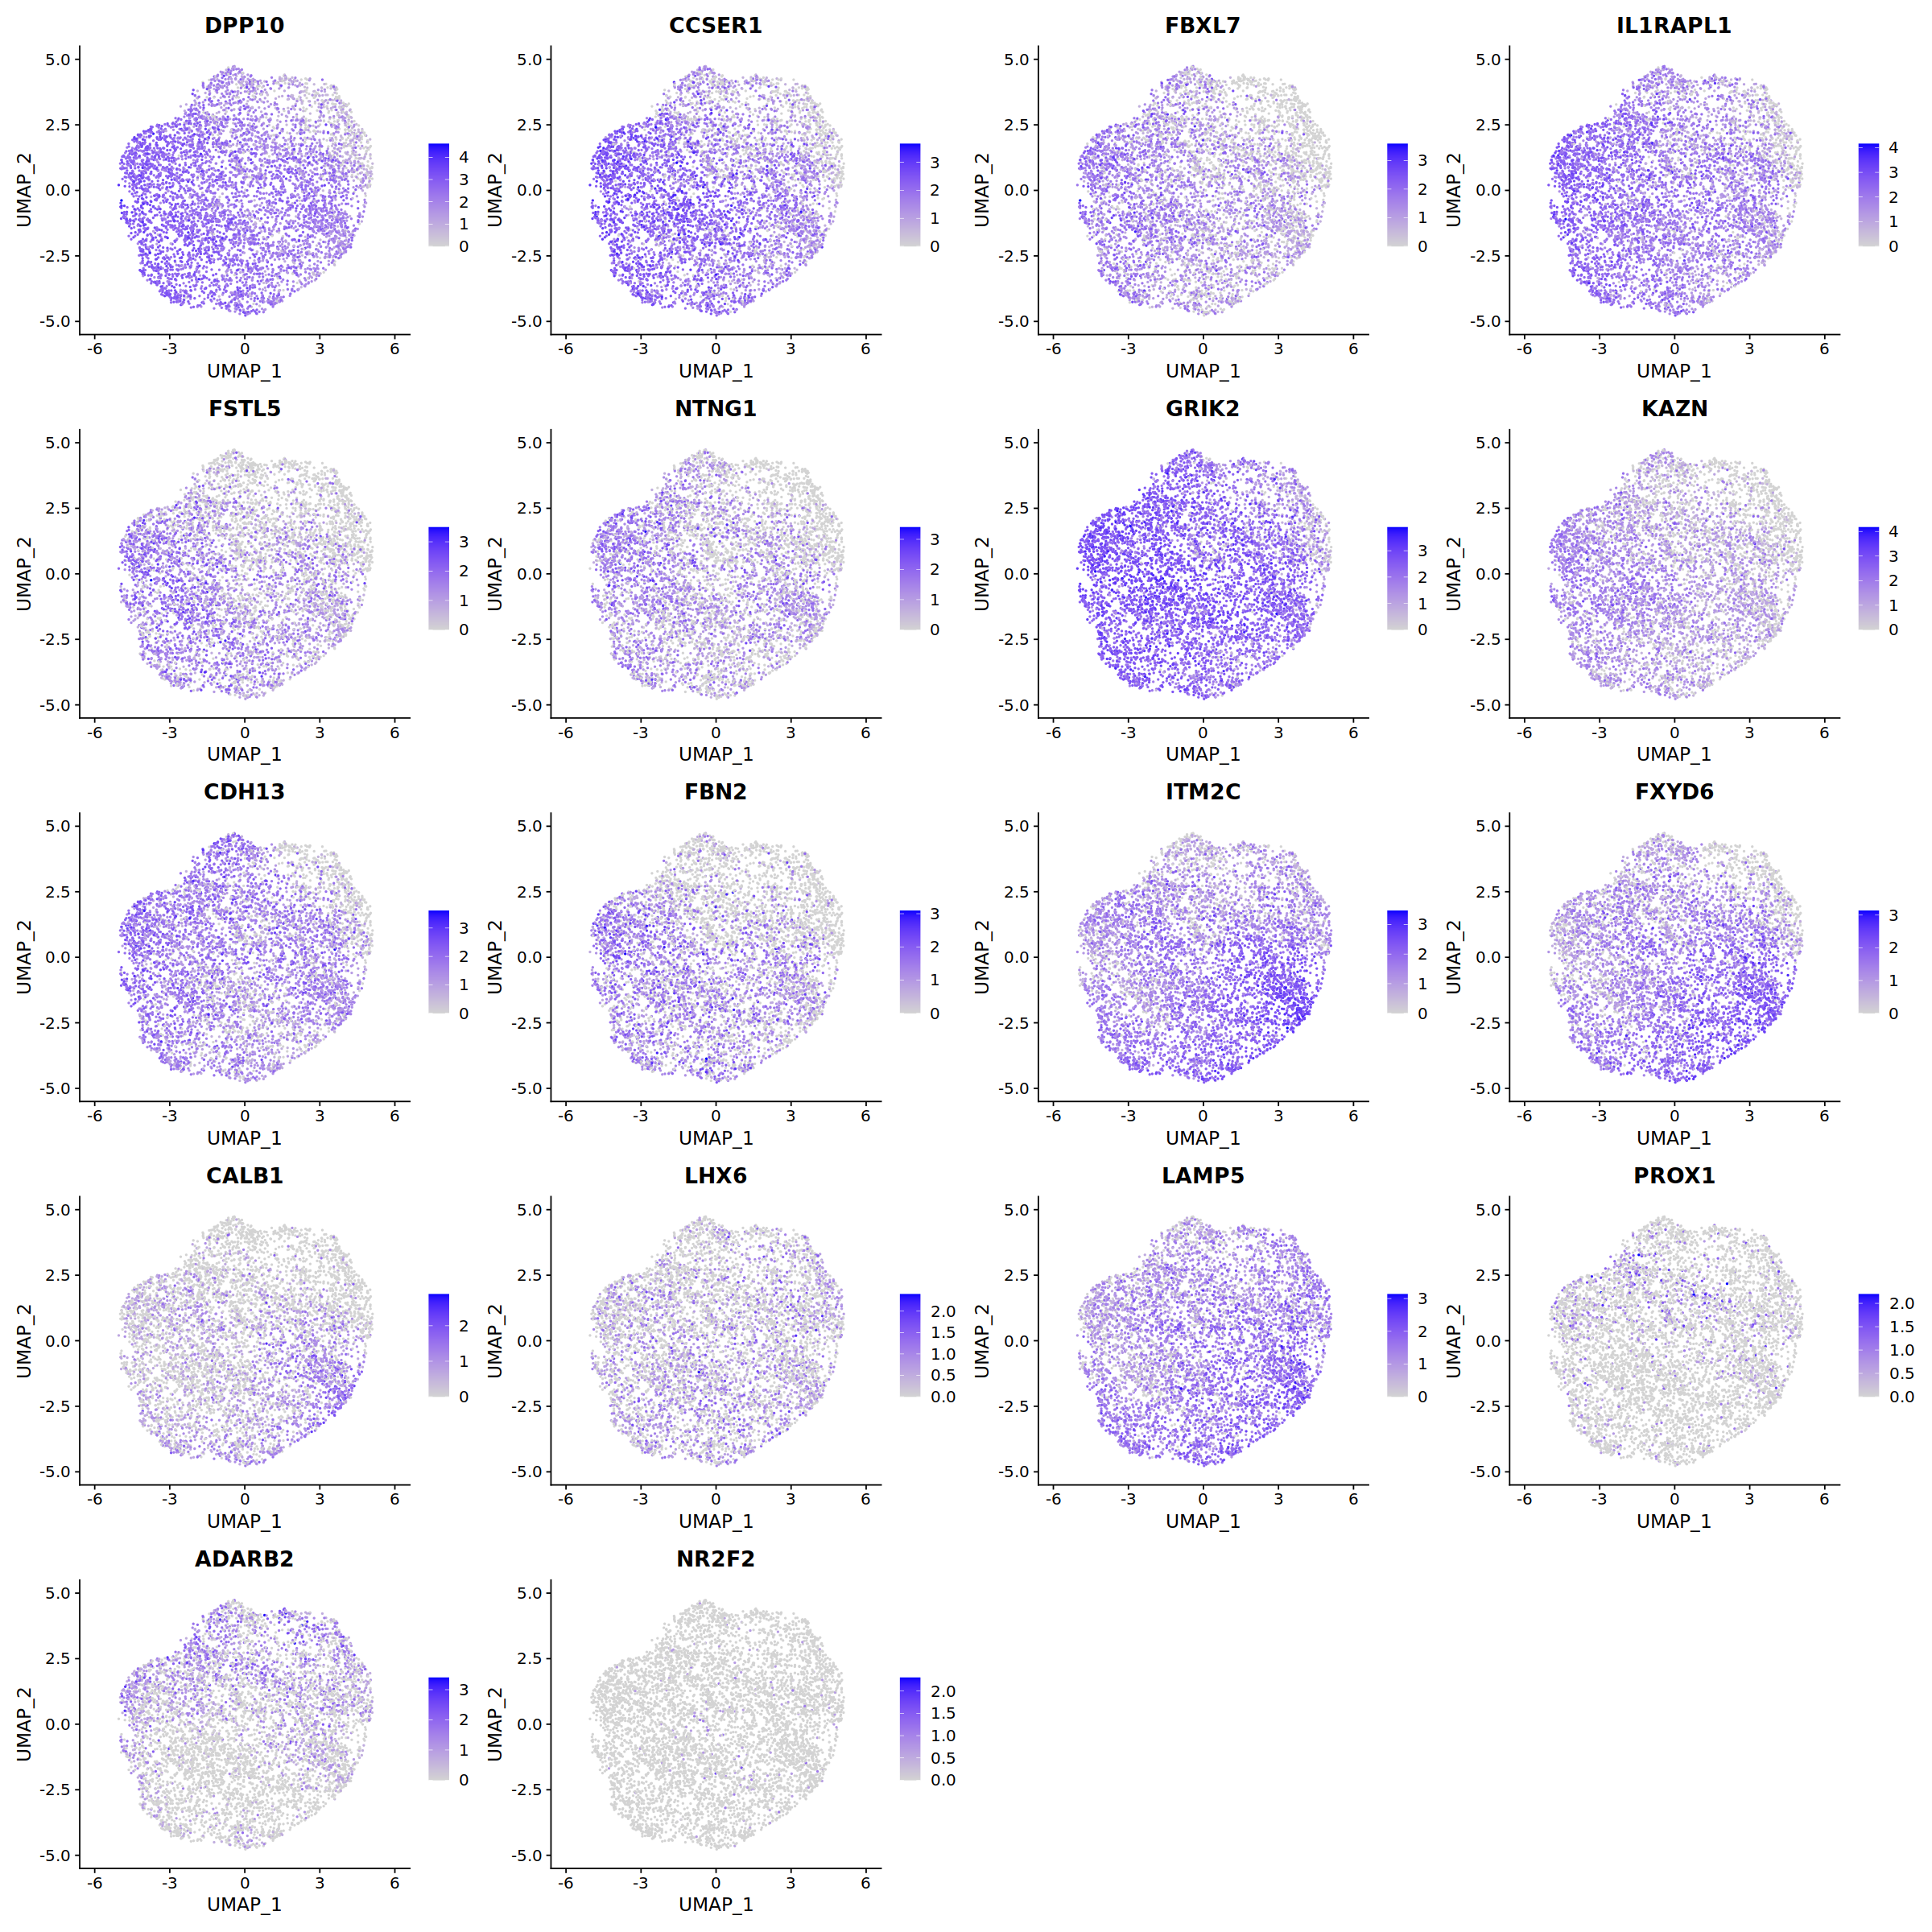

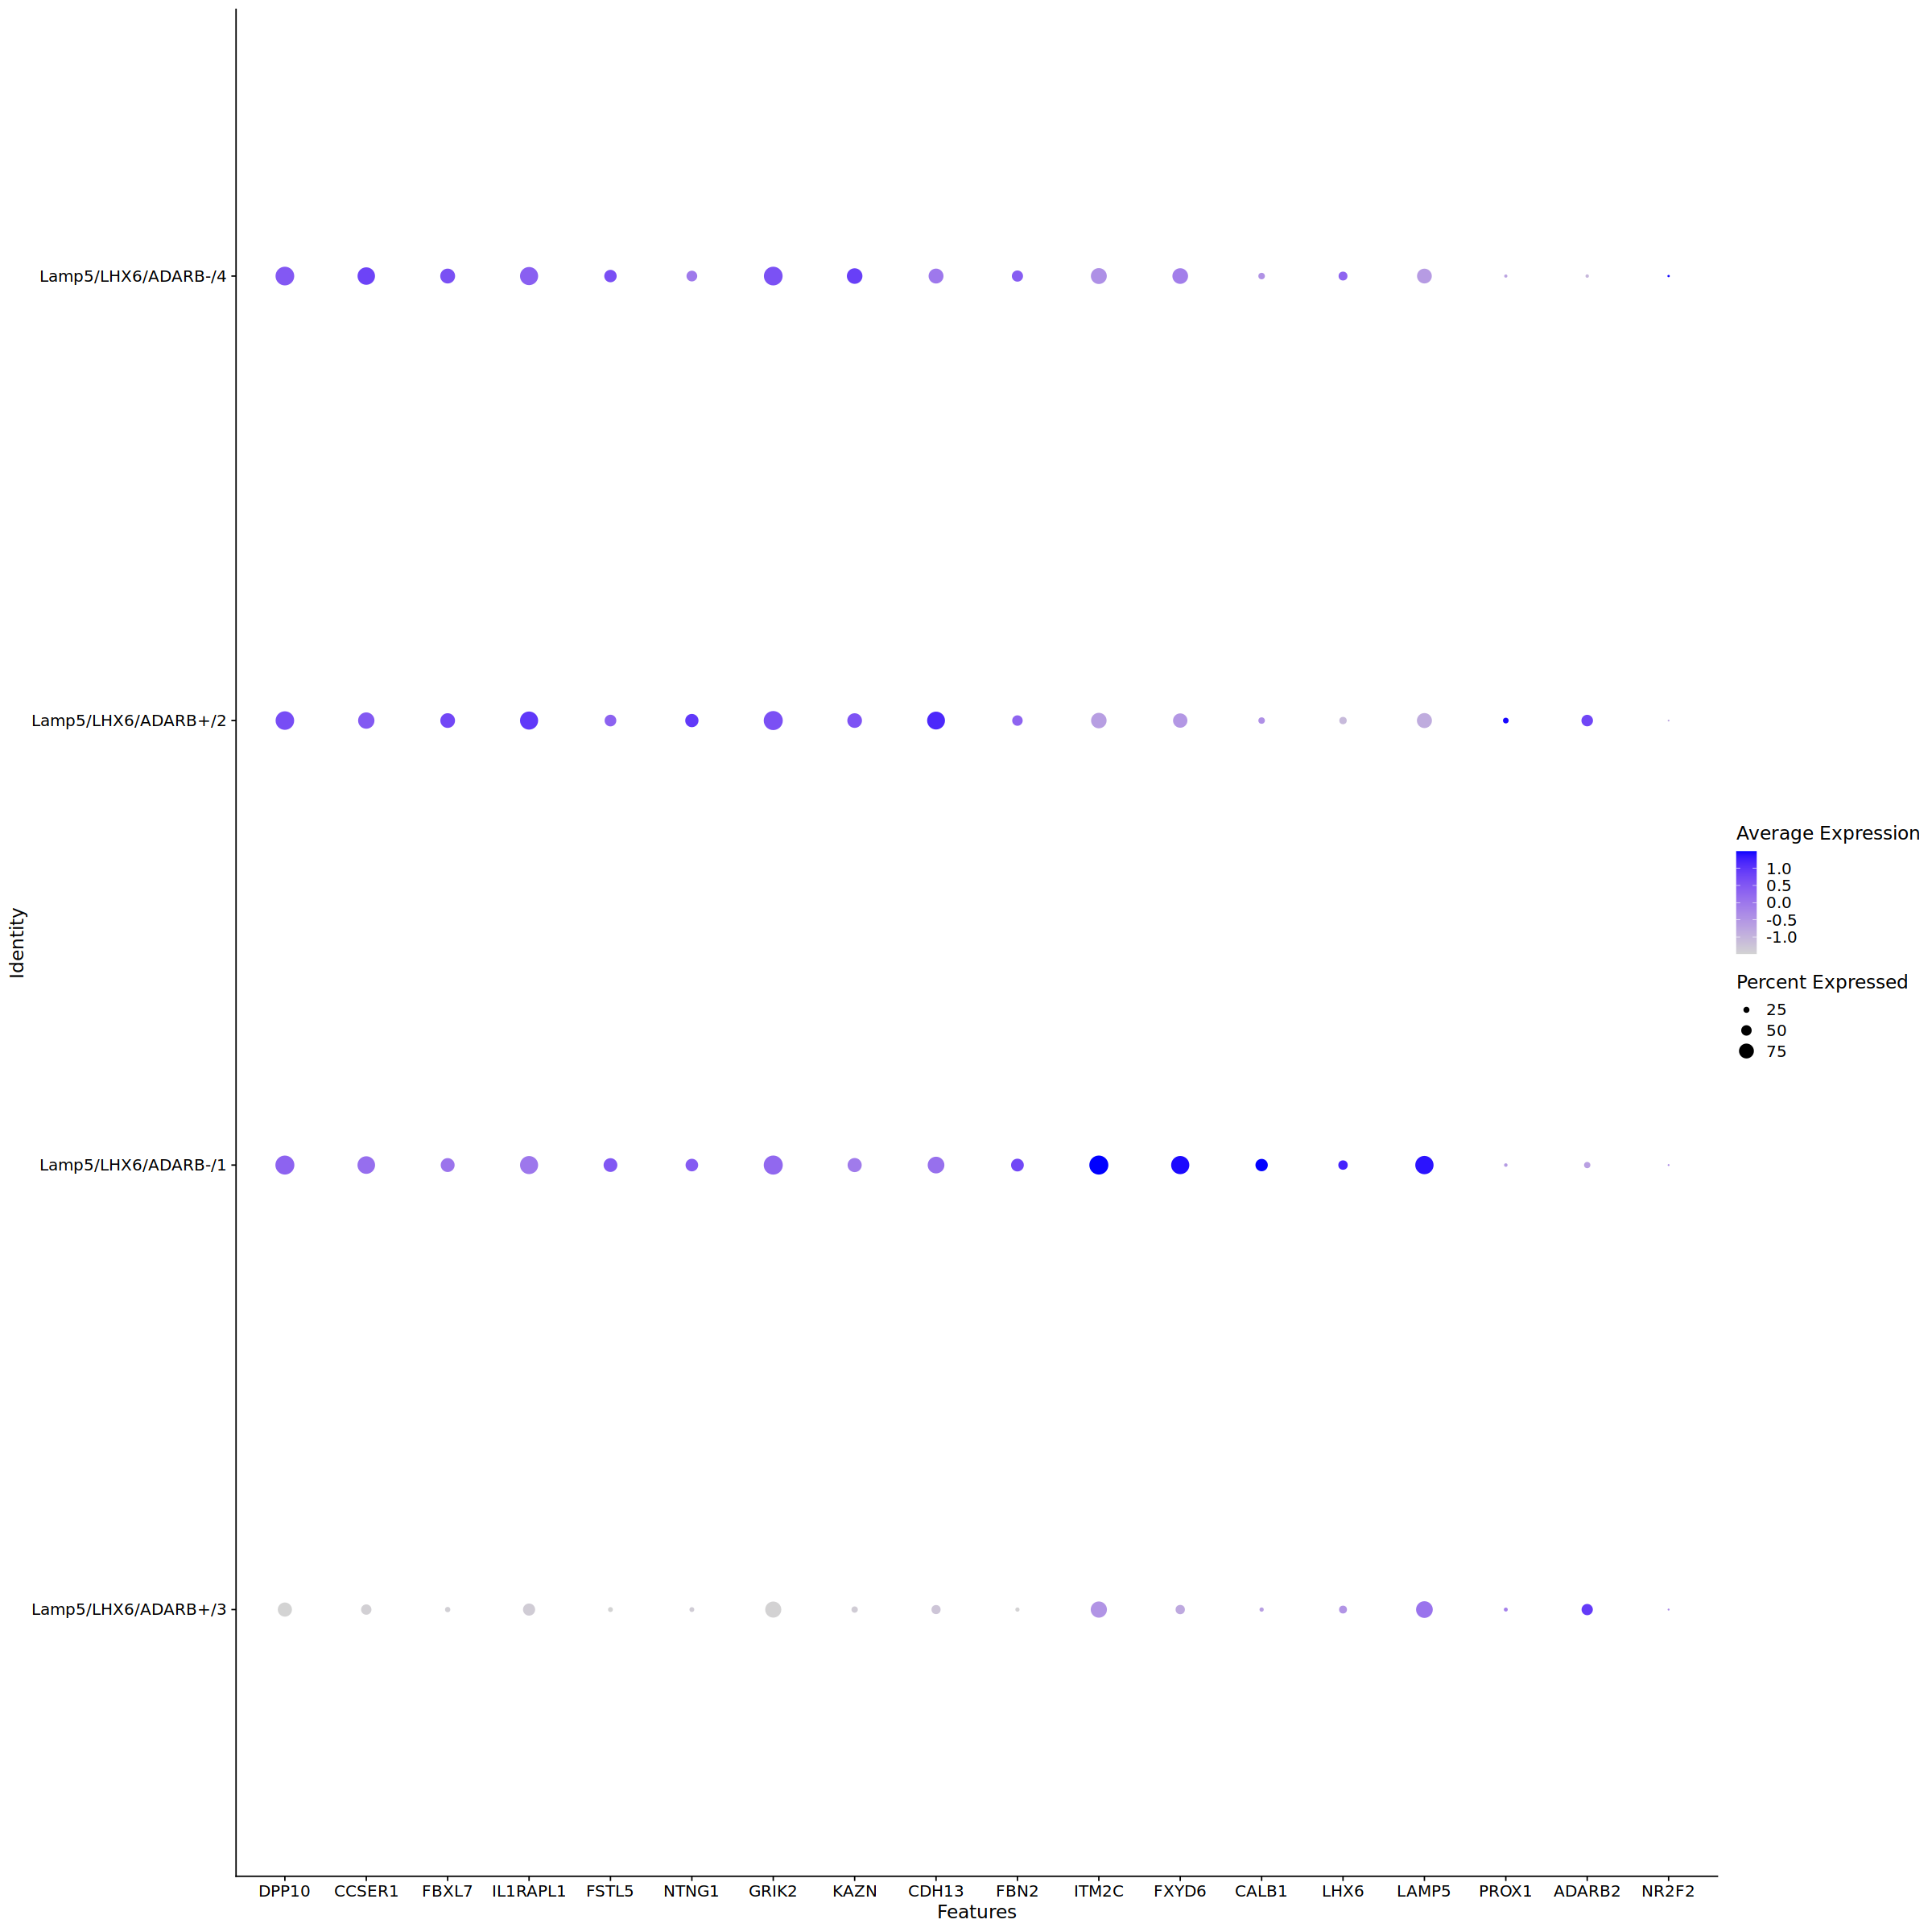

In [59]:

classMarkerTop = c(marker1_1,marker2_1,'LHX6','TAC1','LAMP5','PROX1','ADARB2','NR2F2')
classMarkerTop=unique(classMarkerTop)

options(repr.plot.width=20, repr.plot.height=20)
FeaturePlot(classFiltSeurat, features = classMarkerTop,raster=FALSE)

Idents(classFiltSeurat)='Cluster'
DotPlot(classFiltSeurat, features = classMarkerTop)



In [60]:
marker2_1

[1] "ITM2C" "FXYD6" "CALB1"

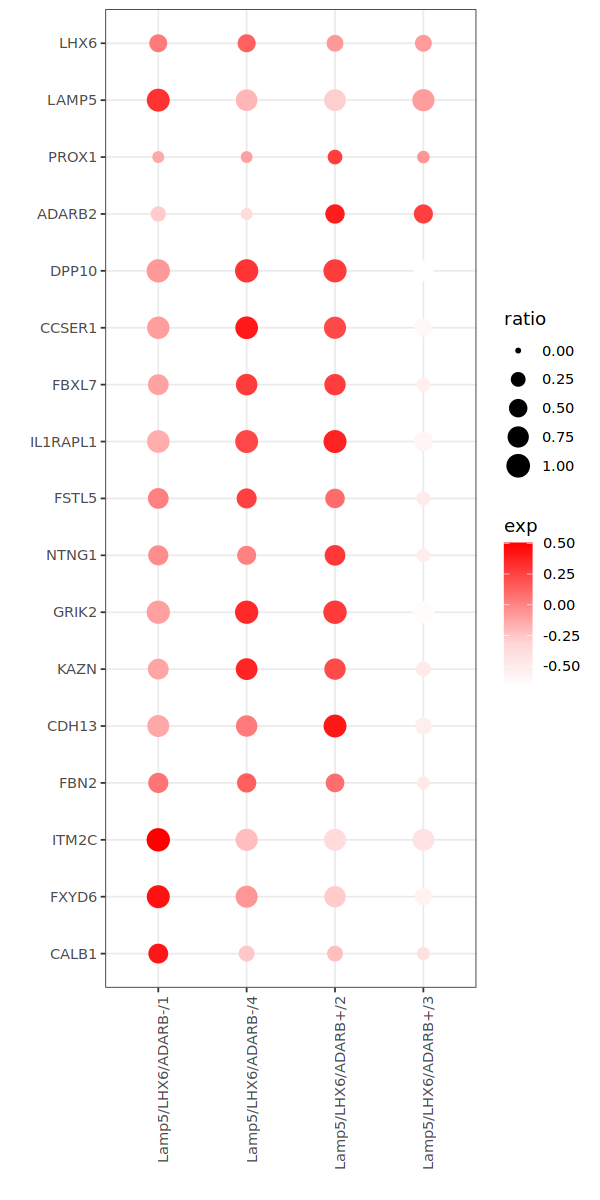

In [62]:

classMarkerTop = c('LHX6','LAMP5','PROX1','ADARB2',marker1_1,marker2_1)
dotplot_genes =classMarkerTop
dotplot_genes=unique(dotplot_genes)
mye.seu=classFiltSeurat
dotplot_genes=intersect(dotplot_genes,rownames(mye.seu[["RNA"]]@data))

mye.seu$celltype=mye.seu$Cluster
mye.seu@meta.data$CB=rownames(mye.seu@meta.data)
bubble.df=as.matrix(mye.seu[["RNA"]]@data[dotplot_genes,])
bubble.df=t(bubble.df)
bubble.df=as.data.frame(scale(bubble.df))
bubble.df$CB=rownames(bubble.df)
bubble.df=merge(bubble.df,mye.seu@meta.data[,c("CB","celltype")],by = "CB")
bubble.df$CB=NULL

celltype_v=c()
gene_v=c()
mean_v=c()
ratio_v=c()
for (i in unique(bubble.df$celltype)) {
  bubble.df_small=bubble.df%>%filter(celltype==i)
  for (j in dotplot_genes) {
    exp_mean=mean(bubble.df_small[,j])
    exp_ratio=sum(bubble.df_small[,j] > min(bubble.df_small[,j])) / length(bubble.df_small[,j])
    celltype_v=append(celltype_v,i)
    gene_v=append(gene_v,j)
    mean_v=append(mean_v,exp_mean)
    ratio_v=append(ratio_v,exp_ratio)
  }
}

plotdf=data.frame(
  celltype=celltype_v,
  gene=gene_v,
  exp=mean_v,
  ratio=ratio_v
)
plotdf$celltype=factor(plotdf$celltype,levels =  sort(unique(plotdf$celltype)))

plotdf$gene=factor(plotdf$gene,levels = rev(as.character(dotplot_genes)))
plotdf$exp=ifelse(plotdf$exp>3,3,plotdf$exp)

plotdf_fil=plotdf[plotdf$gene %in% dotplot_genes,]

#plotdf_fil$celltype=factor(plotdf_fil$celltype,levels = order)

options(repr.plot.width=5, repr.plot.height=10)
gp=ggplot(plotdf_fil,aes(x=celltype,y=gene,size=ratio,color=exp))+geom_point()+
  scale_x_discrete("")+scale_y_discrete("")+
  scale_color_gradientn(colours = c(colorRampPalette(c("white", "#FFD7D7"))(30),colorRampPalette(c("#FFD7D7", "red"))(70)))+
#scale_color_gradientn(colours = c(colorRampPalette(c("white", "red"))(100)))+
  scale_size_continuous(limits = c(0,1))+theme_bw()+
  theme(
    axis.text.x.bottom = element_text(hjust = 1, vjust = 1, angle = 90)
  )
gp




In [63]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/fig6_renew_240307_LHX6/dot.pdf", width=5, height=10)
gp
dev.off()



png 
  2

In [50]:
df_meta=classFiltSeurat@meta.data
df_meta=df_meta[,c('Cluster','species')]


In [51]:
df_meta$num=1
df_print=df_meta %>% group_by(Cluster,species) %>% summarise(num_part=sum(num))
df_print


`summarise()` has grouped output by 'Cluster'. You can override using the
`.groups` argument.


Cluster             species  num_part
1  Lamp5/LHX6/ADARB-/1 macaque  2243    
2  Lamp5/LHX6/ADARB-/1 marmoset   61    
3  Lamp5/LHX6/ADARB-/1 mouse       8    
4  Lamp5/LHX6/ADARB-/4 macaque   692    
5  Lamp5/LHX6/ADARB-/4 marmoset  175    
6  Lamp5/LHX6/ADARB-/4 mouse       4    
7  Lamp5/LHX6/ADARB+/2 macaque  1055    
8  Lamp5/LHX6/ADARB+/2 marmoset  675    
9  Lamp5/LHX6/ADARB+/2 mouse      16    
10 Lamp5/LHX6/ADARB+/3 macaque   178    
11 Lamp5/LHX6/ADARB+/3 marmoset  185    
12 Lamp5/LHX6/ADARB+/3 mouse     517

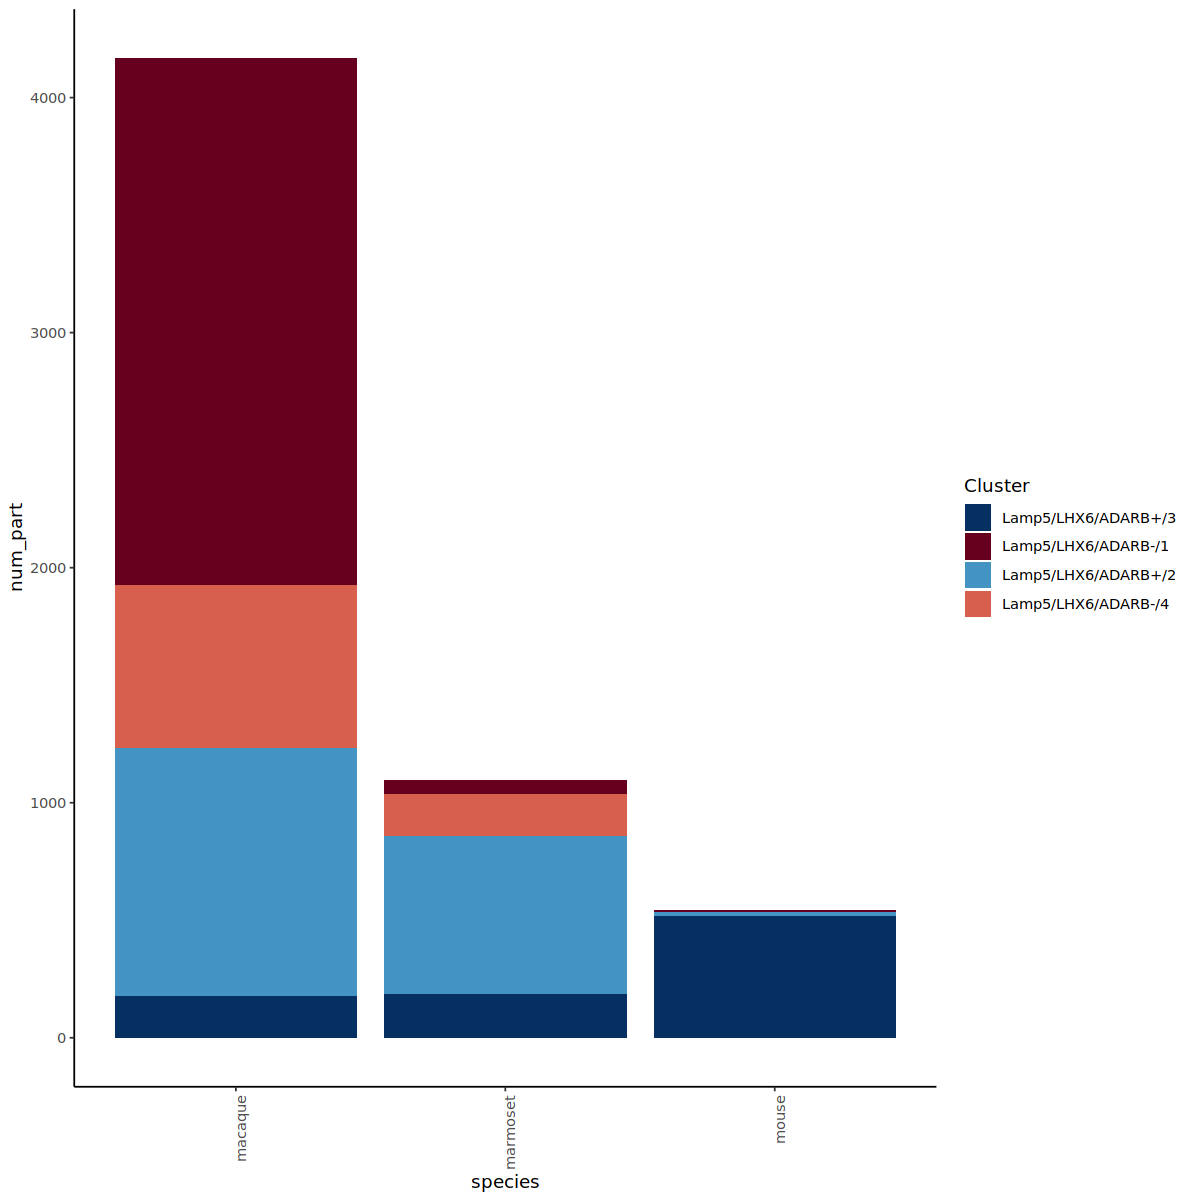

In [52]:
options(repr.plot.width=10, repr.plot.height=10)
p1=ggplot(data = df_print, aes(x = species, y = num_part, fill = Cluster)) +
scale_fill_manual(values =col_d)+
 geom_bar(stat = "identity", position = "stack")+theme_classic()+
 theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1))
p1


In [53]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/fig6_renew_240307_LHX6/species_bar1.pdf", width=10, height=10)
p1
dev.off()

png 
  2

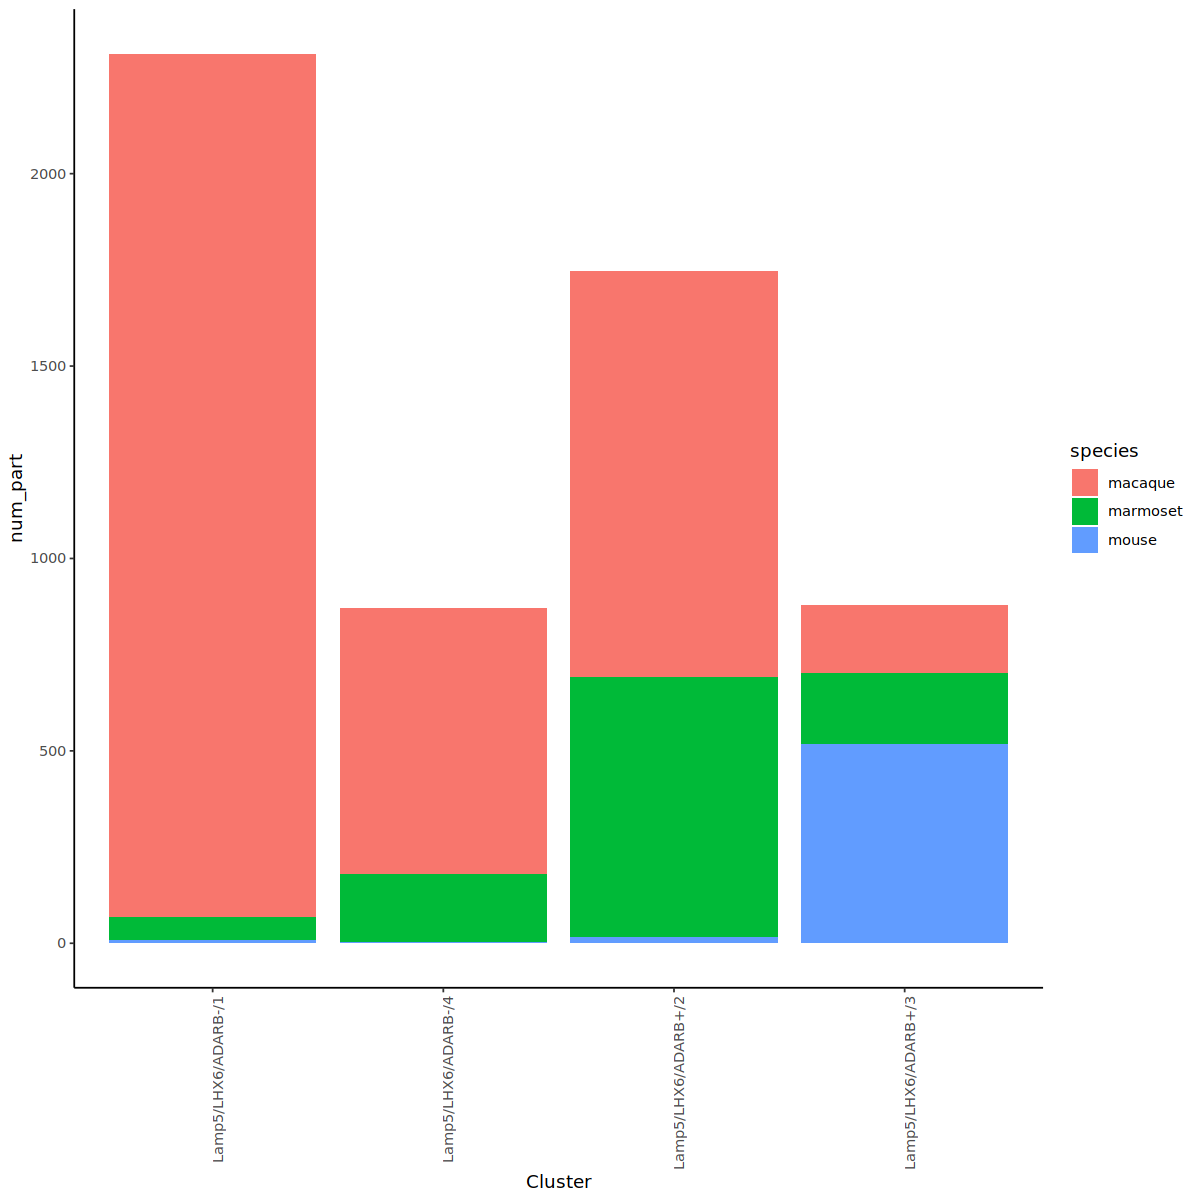

In [68]:
ggplot(data = df_print, aes(x = Cluster, y = num_part, fill = species)) +
 geom_bar(stat = "identity", position = "stack")+theme_classic()+
 theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1))
